In [ ]:
from __future__ import division
import os.path as osp
import sys
import argparse
from tqdm import tqdm
import numpy as np

import torch
import torch.nn as nn
import torch.distributed as dist
import torch.backends.cudnn as cudnn
from torch.nn.modules.batchnorm import BatchNorm2d 

from config import config
from dataloader import get_train_loader
from network import CrfRnnNet
from datasets import Cil

from utils.init_func import init_weight, group_weight
from engine.engine import Engine

import matplotlib.pyplot as plt
%matplotlib inline

## load pretrained

In [ ]:
psp_dict = model.psp.state_dict()
# psp_dict

In [ ]:
ptr_dict = torch.load('./PSP_epoch-75.pth',map_location='cpu')['model']
ptr_dict = {k: v for k, v in ptr_dict.items() if k in psp_dict}

In [ ]:
model = CrfRnnNet(2, n_iter=5)
model.psp.load_state_dict(ptr_dict)

## trainable parameters

In [ ]:
criterion = nn.CrossEntropyLoss(reduction='mean',
                                    ignore_index=-1)
model = CrfRnnNet(config.num_classes, criterion=criterion,
               pretrained_model=config.pretrained_model,
               norm_layer=BatchNorm2d)
base_lr = config.lr

In [ ]:
# initialize parameters
init_weight(model.psp.business_layer, nn.init.kaiming_normal_,
            BatchNorm2d, config.bn_eps, config.bn_momentum,
            mode='fan_in', nonlinearity='relu')


# group weight initialization on all layers
params_list = []
params_list = group_weight(params_list, model.psp.backbone,
                           BatchNorm2d, base_lr)
for module in model.psp.business_layer:
    params_list = group_weight(params_list, module, BatchNorm2d,
                               base_lr * 10)
params_list.append(
    dict(params=list(model.crfrnn.parameters()), weight_decay=.0, lr=base_lr))

## increase batch size of crfasrnn

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from crfasrnn.filters import SpatialFilter, BilateralFilter
from crfasrnn.params import DenseCRFParams

In [ ]:
class CrfRnn(nn.Module):
    """
    PyTorch implementation of the CRF-RNN module described in the paper:

    Conditional Random Fields as Recurrent Neural Networks,
    S. Zheng, S. Jayasumana, B. Romera-Paredes, V. Vineet, Z. Su, D. Du, C. Huang and P. Torr,
    ICCV 2015 (https://arxiv.org/abs/1502.03240).
    """

    def __init__(self, num_labels, num_iterations=5, crf_init_params=None):
        """
        Create a new instance of the CRF-RNN layer.

        Args:
            num_labels:         Number of semantic labels in the dataset
            num_iterations:     Number of mean-field iterations to perform
            crf_init_params:    CRF initialization parameters
        """
        super(CrfRnn, self).__init__()
        if crf_init_params is None:
            crf_init_params = DenseCRFParams()

        self.params = crf_init_params
        self.num_iterations = num_iterations
        self.num_labels = num_labels

        # --------------------------------------------------------------------------------------------
        # --------------------------------- Trainable Parameters -------------------------------------
        # --------------------------------------------------------------------------------------------

        # Spatial kernel weights
        self.spatial_ker_weights = nn.Parameter(
            crf_init_params.spatial_ker_weight
            * torch.eye(num_labels, dtype=torch.float32)
        )

        # Bilateral kernel weights
        self.bilateral_ker_weights = nn.Parameter(
            crf_init_params.bilateral_ker_weight
            * torch.eye(num_labels, dtype=torch.float32)
        )

        # Compatibility transform matrix
        self.compatibility_matrix = nn.Parameter(
            torch.eye(num_labels, dtype=torch.float32)
        )

    def forward(self, image, logits):
        """
        Perform CRF inference.

        Args:
            image:  Tensor of shape (3, h, w) containing the RGB image
            logits: Tensor of shape (num_classes, h, w) containing the unary logits
        Returns:
            log-Q distributions (logits) after CRF inference
        """
        
        # if logits.shape[0] != 1:
        #     raise ValueError("Only batch size 1 is currently supported!")

        # image = image[0]
        # logits = logits[0]

        

        spatial_filter = SpatialFilter(image, gamma=self.params.gamma)
        bilateral_filter = BilateralFilter(
            image, alpha=self.params.alpha, beta=self.params.beta
        )
        _, h, w = image.shape
        cur_logits = logits

        for _ in range(self.num_iterations):
            # print("DANGER!")    #debug
            # Normalization
            q_values = F.softmax(cur_logits, dim=0)

            # Spatial filtering
            spatial_out = torch.mm(
                self.spatial_ker_weights,
                spatial_filter.apply(q_values).view(self.num_labels, -1),
            )

            # Bilateral filtering
            bilateral_out = torch.mm(
                self.bilateral_ker_weights,
                bilateral_filter.apply(q_values).view(self.num_labels, -1),
            )

            # Compatibility transform
            msg_passing_out = (
                spatial_out + bilateral_out
            )  # Shape: (self.num_labels, -1)
            msg_passing_out = torch.mm(self.compatibility_matrix, msg_passing_out).view(
                self.num_labels, h, w
            )

            # Adding unary potentials
            cur_logits = msg_passing_out + logits

        return torch.unsqueeze(cur_logits, 0)


In [ ]:
crfrnn = CrfRnn(num_labels=2, num_iterations=5)

In [ ]:
batch_size = 4
data = torch.randn(batch_size, 3, 512, 512)
psp_fm = torch.randn(batch_size, 2, 512, 512)

In [ ]:
res = torch.zeros(1,2,512,512)
for i in range(batch_size):
    out = crfrnn(data[i], psp_fm[i])
    res = torch.cat((res,out), dim=0)
#     print(out.shape)
res = res[1:]
print(res.shape)

## check parameters of crf

In [29]:
from network import CrfRnnNet

In [15]:
import sklearn

ImportError: cannot import name 'rng_integers'

In [30]:
model = CrfRnnNet(2,n_iter=1)
ptr_model_pth = "log/snapshot/epoch-last.pth"
ptr_dict = torch.load(ptr_model_pth, map_location='cpu')['model']
model.load_state_dict(ptr_dict)

<All keys matched successfully>

In [25]:
model.crfrnn.spatial_ker_weights

Parameter containing:
tensor([[-6.4133,  0.4266],
        [ 1.4159,  2.5658]], requires_grad=True)

In [26]:
model.crfrnn.bilateral_ker_weights

Parameter containing:
tensor([[-4.4116,  0.4101],
        [ 1.4026,  4.5644]], requires_grad=True)

In [27]:
model.crfrnn.compatibility_matrix

Parameter containing:
tensor([[ 6.5834,  1.9520],
        [-5.5908, -0.9594]], requires_grad=True)

In [28]:
for name, param in model.crfrnn.named_parameters():
    if param.requires_grad:
        print(name, param.data)

spatial_ker_weights tensor([[-6.4133,  0.4266],
        [ 1.4159,  2.5658]])
bilateral_ker_weights tensor([[-4.4116,  0.4101],
        [ 1.4026,  4.5644]])
compatibility_matrix tensor([[ 6.5834,  1.9520],
        [-5.5908, -0.9594]])


## check crf layer

In [2]:
from network import CrfRnnNet
import cv2
import os

### main

In [27]:
def func(idx):
    img=cv2.imread("epoch3100/test_"+str(idx)+".png")
    if type(img)==type(None):
        return
    
    data = img.transpose((2, 0, 1))
    data = np.expand_dims(data, axis=0)
    data = torch.tensor(data, dtype=torch.float32)
    
    prob = img/255
    prob[:,:,0] = 1-prob[:,:,1]
    prob = prob[:,:,:2]
    prob = prob.transpose((2, 0, 1))
    prob = np.expand_dims(prob, axis=0)
    prob = torch.tensor(prob, dtype=torch.float32)
    
    model = CrfRnnNet(out_planes=2,n_iter=5)
    out = model.crfrnn(data, prob).detach().cpu().numpy()
    
    res = (out[0,1] * 255).astype(np.uint8)
    cv2.imwrite("epoch3100/"+str(idx)+".png", res)

In [29]:
for i in tqdm(range(230)):
    func(i)

100%|██████████| 230/230 [02:30<00:00,  1.53it/s]


### test

(608, 608, 3)


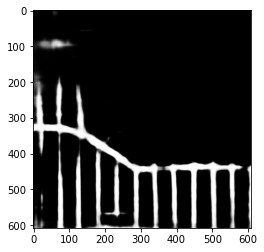

In [3]:
img=cv2.imread("epoch3100/test_191.png")
print(img.shape)
plt.imshow(img)

torch.float32 torch.Size([1, 2, 608, 608])


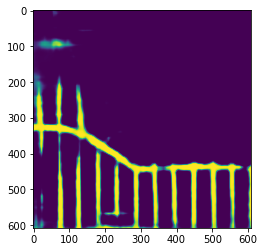

In [4]:
prob = img/255
prob[:,:,0] = 1-prob[:,:,1]
prob = prob[:,:,:2]
prob = prob.transpose((2, 0, 1))

plt.imshow((prob[1] * 255).astype(np.uint8))
cv2.imwrite("prob.png", (prob[1] * 255).astype(np.uint8))
# plt.imshow(np.argmax(prob,axis=0).astype(np.uint8)*255)
# cv2.imwrite("prob.png", np.argmax(prob,axis=0).astype(np.uint8)*255)

prob = np.expand_dims(prob, axis=0)
prob = torch.tensor(prob, dtype=torch.float32)
print(prob.dtype, prob.shape)

In [5]:
data = img.transpose((2, 0, 1)).astype('float32')
data = np.expand_dims(data, axis=0)
data = torch.tensor(data)
print(data.dtype, data.shape)

torch.float32 torch.Size([1, 3, 608, 608])


In [10]:
model = CrfRnnNet(2,n_iter=1)
# ptr_model_pth = "log/snapshot/epoch-last.pth"
# ptr_dict = torch.load(ptr_model_pth, map_location='cpu')['model']
# model.load_state_dict(ptr_dict)
out = model.crfrnn(data, prob).detach().numpy()

True

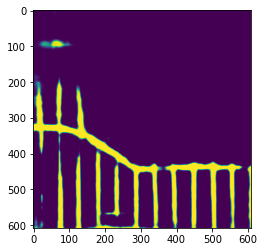

In [11]:
res = (out[0,1] * 255).astype(np.uint8)
plt.imshow(res)
cv2.imwrite("fig.png",res)

In [20]:
out.shape

(1, 2, 608, 608)

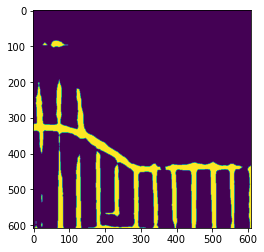

In [34]:
plt.imshow((np.argmax(out[0],axis=0)*255).astype(np.uint8))